In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyproj
import geopandas as gpd
from pysheds.grid import Grid
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.text as mtext
import matplotlib.font_manager as mfonts
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe

%matplotlib inline

In [2]:
import ssl
if hasattr(ssl, '_create_unverified_context'):
    ssl._create_default_https_context = ssl._create_unverified_context
import cartopy.io.img_tiles as cimgt

In [3]:
grid = Grid.from_raster('../../pysheds/data/n30w100_con',
                        data_name='dem', input_type='ascii')

In [4]:
grid.read_raster('../../pysheds/data/n30w100_dir',
                 data_name='dir', input_type='ascii')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [6]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

In [7]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [8]:
# Get a view of the catchment
catch = grid.view('catch')

In [9]:
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [10]:
branches = grid.extract_river_network('catch', 'acc', threshold=100, dirmap=dirmap)

In [11]:
# WGS 84: Geographic
old_crs = pyproj.Proj('+init=epsg:4326')

# NAD83 / Texas Centric Albers Equal Area: Projected
tiles = cimgt.StamenTerrain()
new_crs = pyproj.Proj(tiles.crs.proj4_init)

In [12]:
grid.add_gridded_data(grid.view('dem', nodata=0), 'dem_catch', affine=grid.affine,
                      shape=grid.shape, crs=grid.crs, nodata=0)

In [13]:
dem_vals, dem_coords = grid.view('dem_catch', as_crs=new_crs, return_coords=True)

In [14]:
acc_vals, acc_coords = grid.view('acc', as_crs=new_crs, return_coords=True)

In [15]:
branch_geoms = []
for feature in branches['features']:
    geom = np.asarray(feature['geometry']['coordinates'])
    tx, ty = pyproj.transform(old_crs, new_crs, geom[:,0], geom[:,1])
    new_geom = np.column_stack([tx, ty])
    branch_geoms.append(new_geom)

In [16]:
acc_vals.flat[0] = 0

In [17]:
def add_osgb_scalebar(ax, at_x=(0.1, 0.4), at_y=(0.05, 0.075), max_stripes=5, zorder=0):
    """
    Add a scalebar to a GeoAxes of type cartopy.crs.OSGB (only).

    Args:
    * at_x : (float, float)
        target axes X coordinates (0..1) of box (= left, right)
    * at_y : (float, float)
        axes Y coordinates (0..1) of box (= lower, upper)
    * max_stripes
        typical/maximum number of black+white regions
    """
    # ensure axis is an OSGB map (meaning coords are just metres)
    # assert isinstance(ax.projection, ccrs.OSGB)
    # fetch axes coordinate mins+maxes
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    # set target rectangle in-visible-area (aka 'Axes') coordinates
    ax0, ax1 = at_x
    ay0, ay1 = at_y
    # choose exact X points as sensible grid ticks with Axis 'ticker' helper
    x_targets = [x0 + ax * (x1 - x0) for ax in (ax0, ax1)]
    ll = mpl.ticker.MaxNLocator(nbins=max_stripes, steps=[1,2,4,5,10])
    x_vals = ll.tick_values(*x_targets)
    # grab min+max for limits
    xl0, xl1 = x_vals[0], x_vals[-1]
    # calculate Axes Y coordinates of box top+bottom
    yl0, yl1 = [y0 + ay * (y1 - y0) for ay in [ay0, ay1]]
    # calculate Axes Y distance of ticks + label margins
    y_margin = (yl1-yl0)*0.25

    # fill black/white 'stripes' and draw their boundaries
    fill_colors = ['black', 'white']
    i_color = 0
    for xi0, xi1 in zip(x_vals[:-1],x_vals[1:]):
        # fill region
        ax.fill((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 fill_colors[i_color], zorder=zorder)
        # draw boundary
        ax.plot((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 'black', zorder=zorder)
        i_color = 1 - i_color

    # add short tick lines
    for x in x_vals:
        ax.plot((x, x), (yl0, yl0-y_margin), 'black', zorder=zorder)

    # add a scale legend 'Km'
    font_props = mfonts.FontProperties(size='medium')
    ax.text(
        0.5 * (xl0 + xl1),
        yl1 + y_margin,
        'km',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontproperties=font_props, zorder=zorder)

    # add numeric labels
    for x in x_vals:
        ax.text(x,
                 yl0 - 2 * y_margin,
                 '{:g}'.format((x - xl0) * 0.001),
                 verticalalignment='top',
                 horizontalalignment='center',
                 fontproperties=font_props, zorder=zorder)
        
    patches = []
    framelx = xl0 - (0.1)*(xl1 - xl0)/2
    framely = yl0 - (3.75)*(yl1 - yl0)/2
    framewidth = 1.1*(xl1 - xl0)
    frameheight = 5*(yl1 - yl0)
    fancybox = mpatches.FancyBboxPatch(
        (framelx, framely), framewidth, frameheight,
        boxstyle=mpatches.BoxStyle("Round", pad=0.02))
    patches.append(fancybox)
    collection = PatchCollection(patches, color='white', alpha=0.3, zorder=zorder-1)
    ax.add_collection(collection)

In [18]:
states = gpd.read_file('/Users/mdbartos/Data/GIS/cb_2016_us_state_500k/cb_2016_us_state_500k.shp')
texas = states[states['STUSPS'] == 'TX']
tx_bounds = np.asarray(texas.geometry.total_bounds)[[0, 2, 1, 3]]
tx_bounds = tx_bounds + np.asarray([-1, 1, -0.5, 0.5])

In [19]:
extent = np.asarray(grid.extent) + np.array([-0.005, 0.005, 0, 0.003])

In [20]:
im0 = plt.imshow(grid.view('dem', nodata=np.nan), 
                  extent=grid.extent, zorder=2,
                  cmap='terrain')
plt.close()

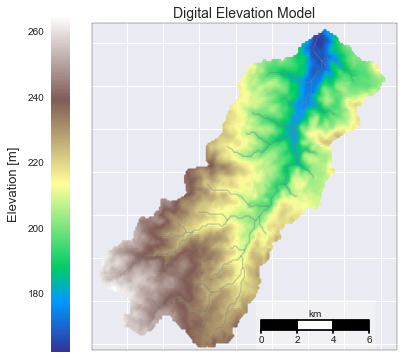

In [21]:
fig = plt.figure(figsize=(6.5,6))
ax = fig.add_subplot(1, 1, 1, projection=tiles.crs)

plt.grid('on', zorder=1)
ax.set_extent(extent)

image_arr_dem = dem_vals[dem_vals != 0]
y_dem = dem_coords[:, 0][(dem_vals != 0).ravel()]
x_dem = dem_coords[:, 1][(dem_vals != 0).ravel()]

sc = ax.scatter(x_dem, y_dem, c=image_arr_dem.ravel(), s=10, cmap='terrain', zorder=5)

add_osgb_scalebar(ax, zorder=5, at_x=(0.6, 0.9), at_y=(0.06, 0.09))

for branch in branch_geoms:
    ax.plot(branch[:,0], branch[:,1], c='slategrey', alpha=0.4, linewidth=1.25, zorder=7)

cbaxes = fig.add_axes([0.1, 0.12, 0.04, 0.78])
cb = plt.colorbar(im0, cax=cbaxes, orientation='vertical')
cbaxes.yaxis.set_ticks_position('left')
cbaxes.yaxis.set_label_position('left')
cb.set_label(label='Elevation [m]', fontsize=13, labelpad=8)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_title('Digital Elevation Model', size=14)

ax.background_patch.set_facecolor('#eaeaf2')
ax.grid('on')

gl0 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='w', alpha=1)

plt.savefig('../img/elev_only', bbox_inches='tight', dpi=200)

In [22]:
projection = pyproj.Proj('+init=epsg:3083')
ca = grid.cell_area(inplace=False, as_crs=projection)

In [23]:
(ca * grid.mask).sum() / 1000000

Raster(82.51171507)